In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Pruning_try

AlextNet_Cifar10.h5  second_try.ipynb  try.ipynb


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Accuracy before pruning: 79.24%
Inference time before pruning: 0.524 ms/sample
Layer conv2d_25 weights reduced by 25%.
Layer conv2d_26 weights reduced by 60%.
Layer conv2d_27 weights reduced by 60%.
Layer conv2d_28 weights reduced by 60%.
Layer conv2d_29 weights reduced by 60%.
Accuracy after reducing weights (before retraining): 14.28%
Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4272 - loss: 1.5487 - val_accuracy: 0.6118 - val_loss: 1.0847
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6264 - loss: 1.0724 - val_accuracy: 0.6648 - val_loss: 0.9789
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6756 - loss: 0.9369 - val_accuracy: 0.7080 - val_loss: 0.8675
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7117 - loss: 0.8455 - val_accuracy: 0.7200 - val_loss: 0.8041
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7307 - loss: 0.7862 - val_accuracy: 0.7172 - val_loss: 0.8266
Epoch 6/50

Accuracy after reducing weights and retraining: 71.74%
Inference time after reducing weights and retraining: 0.371 ms/sample


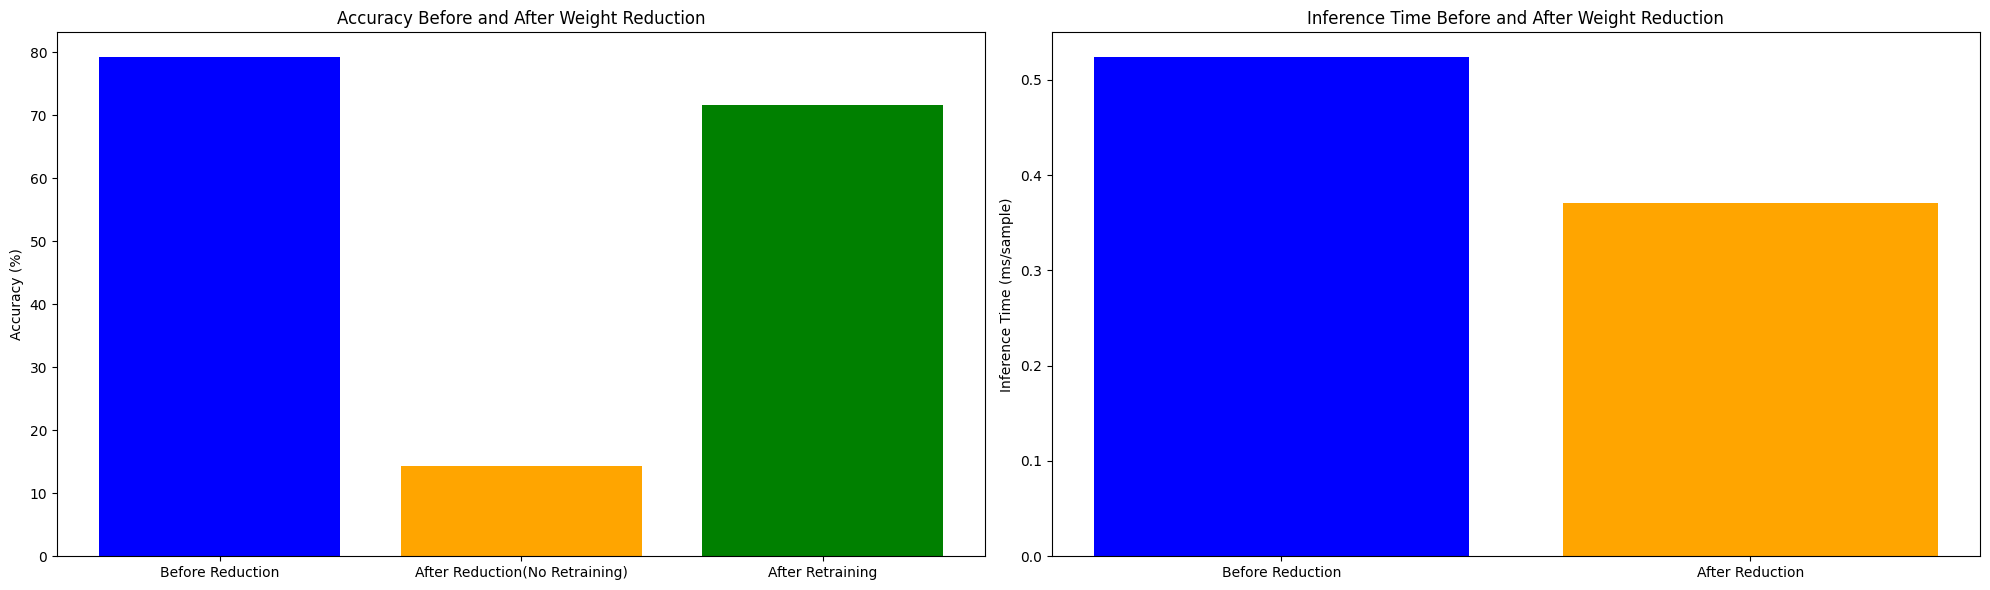

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical operations
import tensorflow as tf  # For model and dataset handling
import matplotlib.pyplot as plt  # For plotting results
import time  # For timing operations

# Function to reduce weights of specific layers by different percentages
def reduce_layer_weights(model, layer_percentages):
    """
    Reduce the weights of specific layers by different percentages.

    Args:
    model -- TensorFlow/Keras model
    layer_percentages -- Dictionary with layer names as keys and reduction percentages as values
    """
    # Iterate over all layers in the model
    for layer in model.layers:
        # Check if the layer is in the list of layers to modify
        if layer.name in layer_percentages:
            percentage = layer_percentages[layer.name]  # Get the pruning percentage for this layer
            factor = 1 - (percentage / 100)  # Compute the reduction factor
            weights = layer.get_weights()  # Get the current weights of the layer
            if len(weights) > 0:  # Check if the layer has weights
                # Reduce the kernel weights by the specified factor
                reduced_kernel = weights[0] * factor
                # Reduce bias if available
                reduced_bias = weights[1] * factor if len(weights) > 1 else None
                # Set the modified weights back to the layer
                if reduced_bias is not None:
                    layer.set_weights([reduced_kernel, reduced_bias])
                else:
                    layer.set_weights([reduced_kernel])
            # Print a confirmation message for the reduction
            print(f"Layer {layer.name} weights reduced by {percentage}%.")

# Function to measure inference time
def measure_inference_time(model, dataset, num_batches=156):
    """
    Measure average inference time for the model.

    Args:
    model -- TensorFlow/Keras model
    dataset -- tf.data.Dataset for evaluation
    num_batches -- Number of batches to measure

    Returns:
    avg_time_per_sample -- Average inference time per sample (milliseconds)
    """
    total_time = 0  # Accumulate total inference time
    total_samples = 0  # Accumulate the total number of samples processed

    # Iterate through the specified number of batches in the dataset
    for i, (x_batch, _) in enumerate(dataset.take(num_batches)):
        start_time = time.time()  # Record the start time for the batch
        _ = model(x_batch, training=False)  # Perform inference without updating weights
        total_time += time.time() - start_time  # Add the time for this batch
        total_samples += x_batch.shape[0]  # Increment the total sample count

    avg_time_per_sample = total_time / total_samples  # Compute average time per sample
    return avg_time_per_sample * 1e3  # Return time in milliseconds per sample

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the data to [0, 1]
y_train, y_test = y_train.flatten(), y_test.flatten()  # Flatten labels for compatibility

# Create a dataset for testing
batch_size = 32  # Define batch size
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Load the pre-trained model from an .h5 file
model_path = "/content/drive/MyDrive/Pruning_try/AlextNet_Cifar10.h5"  # Path to the model file
model = tf.keras.models.load_model(model_path)
# Compile the model with optimizer, loss, and metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Measure accuracy before pruning
loss_before_pruning, accuracy_before_pruning = model.evaluate(dataset_test, verbose=0)
print(f"Accuracy before pruning: {accuracy_before_pruning * 100:.2f}%")

# Measure inference time before pruning
inference_time_before = measure_inference_time(model, dataset_test)
print(f"Inference time before pruning: {inference_time_before:.3f} ms/sample")

# Reduce weights for specified layers by different percentages
layer_percentages = {
    "conv2d_25": 25,  # Reduce weights in conv2d_25 by 25%
    "conv2d_26": 60,  # Reduce weights in conv2d_26 by 60%
    "conv2d_27": 60,  # Reduce weights in conv2d_27 by 60%
    "conv2d_28": 60,  # Reduce weights in conv2d_28 by 60%
    "conv2d_29": 60   # Reduce weights in conv2d_29 by 60%
}  # Specify reduction percentages for each layer
reduce_layer_weights(model, layer_percentages)

# Measure accuracy after reducing weights but before retraining
loss_after_reduction, accuracy_after_reduction = model.evaluate(dataset_test, verbose=0)
print(f"Accuracy after reducing weights (before retraining): {accuracy_after_reduction * 100:.2f}%")

# Retrain the model after reducing weights
model.fit(x_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.1)
# Save the retrained model to a new .h5 file
model.save('/content/drive/MyDrive/Pruning_try/conv_pruned_trained_alexnet.h5')

# Measure accuracy after retraining
loss_after_retraining, accuracy_after_retraining = model.evaluate(dataset_test, verbose=0)
print(f"Accuracy after reducing weights and retraining: {accuracy_after_retraining * 100:.2f}%")

# Measure inference time after reducing weights and retraining
inference_time_after = measure_inference_time(model, dataset_test)
print(f"Inference time after reducing weights and retraining: {inference_time_after:.3f} ms/sample")

# Plot results
labels = ["Before Reduction", "After Reduction(No Retraining)", "After Retraining"]
# Prepare data for accuracy plot
accuracy_values = [accuracy_before_pruning * 100, accuracy_after_reduction * 100, accuracy_after_retraining * 100]
# Prepare data for inference time plot
times = [inference_time_before, inference_time_after]

plt.figure(figsize=(20, 6))  # Define figure size

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(labels, accuracy_values, color=['blue', 'orange', 'green'])  # Bar plot for accuracy
plt.ylabel("Accuracy (%)")  # Label y-axis
plt.title("Accuracy Before and After Weight Reduction")  # Add title

# Inference time plot
plt.subplot(1, 2, 2)
plt.bar(["Before Reduction", "After Reduction"], times, color=['blue', 'orange'])  # Bar plot for inference time
plt.ylabel("Inference Time (ms/sample)")  # Label y-axis
plt.title("Inference Time Before and After Weight Reduction")  # Add title

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plots


In [ ]:
# Load the model from .h5 file
model_path = "/content/drive/MyDrive/Pruning_try/AlextNet_Cifar10.h5"  # Replace with the path to your .h5 file
model = tf.keras.models.load_model(model_path)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Measure accuracy before pruning
loss_before_pruning, accuracy_before_pruning = model.evaluate(dataset_test, verbose=0)
print(f"Accuracy before pruning: {accuracy_before_pruning * 100:.2f}%")
# Measure inference time before pruning
inference_time_before = measure_inference_time(model, dataset_test)
print(f"Inference time before pruning: {inference_time_before:.3f} ms/sample")

Accuracy before pruning: 79.24%
Inference time before pruning: 0.384 ms/sample


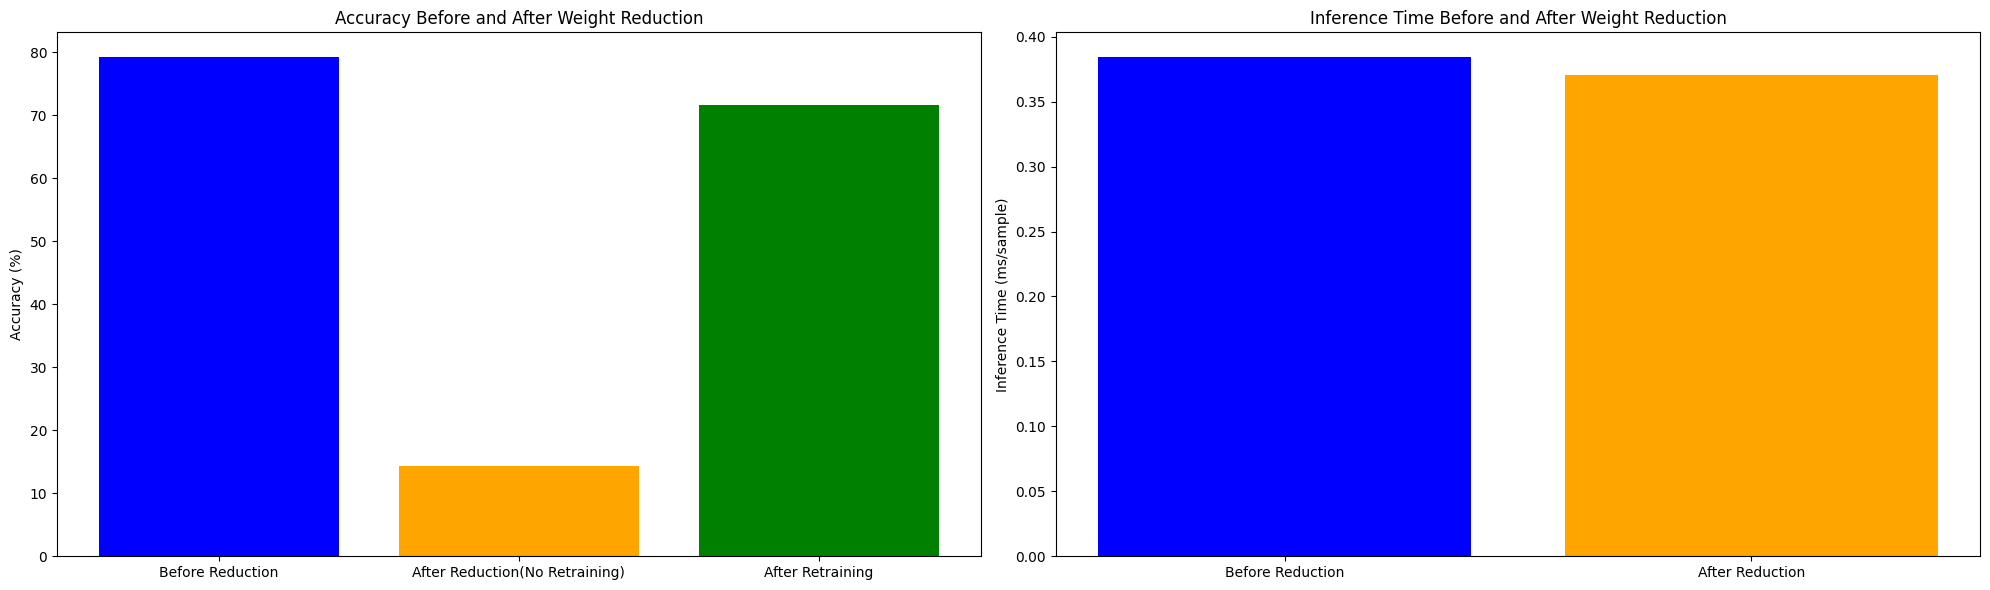

In [ ]:
# Plot results
labels = ["Before Reduction", "After Reduction(No Retraining)", "After Retraining"]
accuracy_values = [accuracy_before_pruning * 100, accuracy_after_reduction * 100, accuracy_after_retraining * 100]
times = [inference_time_before, inference_time_after]

plt.figure(figsize=(20, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.bar(labels, accuracy_values, color=['blue', 'orange', 'green'])
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Before and After Weight Reduction")

# Inference time plot
plt.subplot(1, 2, 2)
plt.bar(["Before Reduction", "After Reduction"], times, color=['blue', 'orange'])
plt.ylabel("Inference Time (ms/sample)")
plt.title("Inference Time Before and After Weight Reduction")

plt.tight_layout()
plt.show()


In [ ]:
model_path = "/content/drive/MyDrive/Pruning_try/conv_pruned_trained_alexnet.h5"  # Replace with the path to your .h5 file
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 56)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 120)         │         168,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 192)           │         207,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 8, 8, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,343,716 (35.64 MB)

 Trainable params: 9,343,714 (35.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)